# Guitar-note-recognition

### Exploring how one can recognize guitar notes by signal processing

### Introduction

### Theory

##### What is a guitar note?

 First of all a note is ...

 Tempered tuning...
 
 
 When you pluck a guitar string, you determine the initial shape (displacement) and velocity of the string. The vibration of the string is governed by the one‐dimensional waveequation:

$$
\begin{cases}
    u_{tt}(x,t) = c^2 u_{xx}(x,t), & 0 < x < L, \quad t > 0 \\[8pt]
    u(0,t) = 0, \quad u(L,t) = 0, & t \geq 0 \\[8pt]
    u(x,0) = f(x), & 0 \leq x \leq L \\[8pt]
    u_t(x,0) = g(x), & 0 \leq x \leq L
\end{cases}
$$


Furthermore, we know that the solution to the waveequation is equivalent to an infinite sum of eigenfunctions.

$$
u(x,t) = \sum_{n=1}^{\infty} A_n \sin\left(\frac{n\pi x}{L}\right) \cos\left(\frac{n\pi c\,t}{L}\right)
$$

This is in music theory known as overtones or harmonics. We have the dominant frequency for $n = 1$, but the solution is not a single wave and thus we get a frequency-spectrum. Therefore, we need to pick out the dominant frequency by a Fourier transform.


##### Implementing the Fourier transform:

The Fourier Transform is an integral-transformation which we can use to decompose a time-domain single into the frequency-domain...

##### Identifying the note

Musical notes are based on the distance to a reference pitch, which most often in Western music is A4 with $f_{\text{A4}} = 440\,\text{Hz}$. Futhermore, Western music also utilizes 12-tone equal temperament meaning that each octave is divided into 12 steps "(...) such that the ratio of the frequencies of any adjacent pair of notes is the same."  https://en.wikipedia.org/wiki/Equal_temperament

This means that for each note $n$, where $n=0$ is A4, we have:

$$
f_{n} = 440\cdot 2^{\frac{n}{12}} \,\text{Hz}
$$
giving us that 

$$
n = 12\cdot \log_{2}\left(\frac{f_n}{440\,\text{Hz}}\right)
$$

However, this introduces a problem as the guitar is not tuned to perfect equal temperament and will not be perfectly tuned to $f_\text{A4} = 440\,\text{Hz}$ either. Instead a guitar will be compromised due to fixed frets. So down the neck the frets are spaced to follow the 12-tone formula. However, the frets spaced equally for each string which gives error as each string has a slightly different ideal placement. https://acousticguitar.com/why-your-guitar-wont-play-perfectly-in-tune-and-why-thats-ok/

We will however assume tempered tuning using the midi-standard in the beginning and modify if we see that it is nescessary. 



##### Noise Reduction

##### Measuring time and f sharply

### Method

### Implementation

In [14]:
### Pseudocode

# 1. Import a wav file

# 2. Remove noise 

# 3. Divide signal into time windows

# 4. For each time window:
# a. Do a Fourier-transform with FFT
# b. Identify dominant frequencies
# c. Map frequencies into notes



In [15]:
### Import basic libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy


In [16]:
### Reading wave-file
import wave

def read_wav(file_path):
    """
    Reads a WAV file and returns the sample rate and audio data as a NumPy array.
    """
    with wave.open(file_path, 'rb') as wav_file:
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        audio_data = np.frombuffer(wav_file.readframes(num_frames), dtype=np.int16)
    return sample_rate, audio_data



In [ ]:
### Generate example file

import numpy as np
import wave

def generate_sine_wave(frequency=440, duration=2, sample_rate=44100, amplitude=32767):
    """
    Generates a sine wave and saves it as a WAV file.

    Parameters:
    - frequency: Frequency of the sine wave in Hz (default 440 Hz for A4).
    - duration: Duration of the generated wave in seconds (default 2 seconds).
    - sample_rate: Sampling rate in Hz (default 44100 Hz).
    - amplitude: Amplitude of the wave (default 32767 for 16-bit PCM audio).

    Returns:
    - File path of the generated WAV file.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = (amplitude * np.sin(2 * np.pi * frequency * t)).astype(np.int16)

    file_path = f"C:/Users/victo/Documents/Github/GuitarRecognition/data/example_{frequency}Hz.wav"
    with wave.open(file_path, "w") as wav_file:
        wav_file.setnchannels(1)  # Mono
        wav_file.setsampwidth(2)  # 16-bit PCM
        wav_file.setframerate(sample_rate)
        wav_file.writeframes(waveform.tobytes())

    return file_path


In [18]:
# Define the mapping of semitone index to note name (using sharps)
NOTE_NAMES = ['A', 'A#', 'B', 'C', 'C#', 'D', 
              'D#', 'E', 'F', 'F#', 'G', 'G#']

def note_to_offset(note):
    """
    Given a note name (e.g., 'C4' or 'A#3'), calculate the semitone offset from A4 (440 Hz).
    """
    # Determine if the note has an accidental (sharp)
    if len(note) >= 3 and note[1] == '#':
        pitch = note[:-1]  # e.g., 'C#'
        octave = int(note[-1])
    else:
        pitch = note[0]    # e.g., 'E'
        octave = int(note[1:])
        
    # Get raw index from NOTE_NAMES
    raw_index = NOTE_NAMES.index(pitch)
    
    # Adjust for octave: notes C and above are considered part of the next octave in this scheme
    if raw_index >= NOTE_NAMES.index("C"):
        semitone_adjust = raw_index - 12
    else:
        semitone_adjust = raw_index
        
    offset = (octave - 4) * 12 + semitone_adjust
    return offset

def offset_to_note(offset):
    """
    Convert a semitone offset (relative to A4) into its note name (e.g., 'C4').
    This version uses the MIDI note number for correct octave handling.
    """
    midi = offset + 69  # MIDI note number for A4 is 69
    note_name = NOTE_NAMES[(midi - 9) % 12]  # Adjust index so that MIDI 69 maps to 'A'
    octave = (midi // 12) - 1
    return f"{note_name}{octave}"

def offset_to_freq(offset):
    """
    Convert a semitone offset (relative to A4) into frequency in Hz.
    """
    return 440 * 2**(offset/12)

# Number of frets on the guitar
num_frets = 24

# Standard tuning for a 6-string guitar (string number : open note)
tuning = {
    6: "E2",
    5: "A2",
    4: "D3",
    3: "G3",
    2: "B3",
    1: "E4"
}

# Dictionary to store the computed notes and frequencies for each string.
# The structure: guitar_notes[string_number] = [(fret, note_name, frequency), ...]
guitar_notes = {}

for string, open_note in tuning.items():
    open_offset = note_to_offset(open_note)
    notes_for_string = []
    for fret in range(num_frets + 1):
        current_offset = open_offset + fret
        note_name = offset_to_note(current_offset)
        freq = offset_to_freq(current_offset)
        notes_for_string.append((fret, note_name, freq))
    guitar_notes[string] = notes_for_string


In [19]:

# Example: print the computed information for string 6 (low E)
for fret, note_name, freq in guitar_notes[6]:
    print(f"String 6, Fret {fret}: {note_name} - {freq:.2f} Hz")


String 6, Fret 0: E2 - 82.41 Hz
String 6, Fret 1: F2 - 87.31 Hz
String 6, Fret 2: F#2 - 92.50 Hz
String 6, Fret 3: G2 - 98.00 Hz
String 6, Fret 4: G#2 - 103.83 Hz
String 6, Fret 5: A2 - 110.00 Hz
String 6, Fret 6: A#2 - 116.54 Hz
String 6, Fret 7: B2 - 123.47 Hz
String 6, Fret 8: C3 - 130.81 Hz
String 6, Fret 9: C#3 - 138.59 Hz
String 6, Fret 10: D3 - 146.83 Hz
String 6, Fret 11: D#3 - 155.56 Hz
String 6, Fret 12: E3 - 164.81 Hz
String 6, Fret 13: F3 - 174.61 Hz
String 6, Fret 14: F#3 - 185.00 Hz
String 6, Fret 15: G3 - 196.00 Hz
String 6, Fret 16: G#3 - 207.65 Hz
String 6, Fret 17: A3 - 220.00 Hz
String 6, Fret 18: A#3 - 233.08 Hz
String 6, Fret 19: B3 - 246.94 Hz
String 6, Fret 20: C4 - 261.63 Hz
String 6, Fret 21: C#4 - 277.18 Hz
String 6, Fret 22: D4 - 293.66 Hz
String 6, Fret 23: D#4 - 311.13 Hz
String 6, Fret 24: E4 - 329.63 Hz


In [ ]:
from scipy.signal import stft

def analyze_stft(file_path, window_size=2048, hop_size=1024, window_type='hann'):
    """
    Reads an audio file, computes its short-time Fourier transform (STFT), 
    and identifies the dominant frequency in each time frame.
    
    Parameters:
    - file_path: Path to the WAV file.
    - window_size: Number of samples per window.
    - hop_size: Number of samples between successive windows.
    - window_type: Type of window to apply (default 'hann').
    
    Returns:
    - times: Array of time bins corresponding to each STFT window.
    - dominant_frequencies: Array of dominant frequency (in Hz) per time frame.
    - f: Frequency bins from the STFT.
    - Zxx: STFT complex spectrum.
    """
    # Read the audio file.
    sample_rate, audio_data = read_wav(file_path)
    
    # Compute the STFT.
    f, t, Zxx = stft(audio_data, fs=sample_rate, window='hann', nperseg=window_size, noverlap=window_size-hop_size)
    
    # For each time slice, find the frequency with maximum magnitude.
    dominant_frequencies = []
    for i in range(Zxx.shape[1]):
        # Consider only positive frequencies by default (f is positive when fs > 0)
        magnitudes = np.abs(Zxx[:, i])
        idx = np.argmax(magnitudes)
        dominant_frequencies.append(f[idx])
        
    return t, np.array(dominant_frequencies), f, Zxx




Time 0.000 s: Dominant frequency = 430.66 Hz
Time 0.023 s: Dominant frequency = 430.66 Hz
Time 0.046 s: Dominant frequency = 430.66 Hz
Time 0.070 s: Dominant frequency = 430.66 Hz
Time 0.093 s: Dominant frequency = 430.66 Hz
Time 0.116 s: Dominant frequency = 430.66 Hz
Time 0.139 s: Dominant frequency = 430.66 Hz
Time 0.163 s: Dominant frequency = 430.66 Hz
Time 0.186 s: Dominant frequency = 430.66 Hz
Time 0.209 s: Dominant frequency = 430.66 Hz
Time 0.232 s: Dominant frequency = 430.66 Hz
Time 0.255 s: Dominant frequency = 430.66 Hz
Time 0.279 s: Dominant frequency = 430.66 Hz
Time 0.302 s: Dominant frequency = 430.66 Hz
Time 0.325 s: Dominant frequency = 430.66 Hz
Time 0.348 s: Dominant frequency = 430.66 Hz
Time 0.372 s: Dominant frequency = 430.66 Hz
Time 0.395 s: Dominant frequency = 430.66 Hz
Time 0.418 s: Dominant frequency = 430.66 Hz
Time 0.441 s: Dominant frequency = 430.66 Hz
Time 0.464 s: Dominant frequency = 430.66 Hz
Time 0.488 s: Dominant frequency = 430.66 Hz
Time 0.511

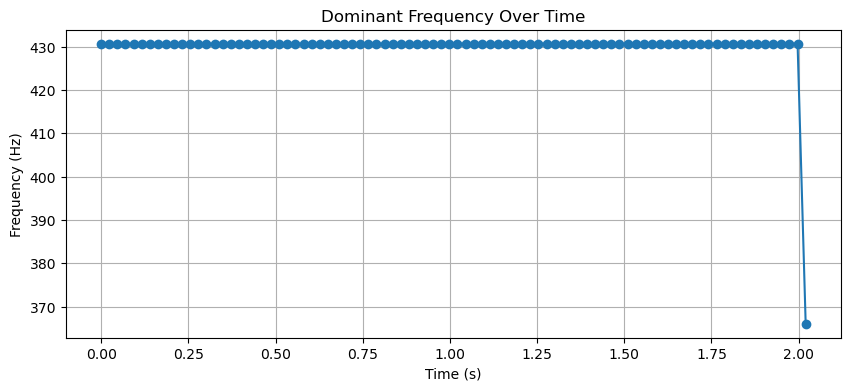

In [ ]:

file_path = generate_sine_wave()

# Analyze the audio file using STFT.
times, dominant_frequencies, f, Zxx = analyze_stft(file_path)

# Plot the dominant frequency over time.
plt.figure(figsize=(10, 4))
plt.plot(times, dominant_frequencies, marker='o', linestyle='-')
plt.title("Dominant Frequency Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.show()

We see that we get 430 Hz. This is from the bin size. However, reducin this means that we get greater time-intervals which means that we possibly can not pick up everything. So we now want to introduce an interpolation. We also see that it falls rapidly at the end. To fix this, we need to not include the endpoints.

Time 0.023 s: Refined frequency = 439.29 Hz
Time 0.046 s: Refined frequency = 439.29 Hz
Time 0.070 s: Refined frequency = 439.29 Hz
Time 0.093 s: Refined frequency = 439.29 Hz
Time 0.116 s: Refined frequency = 439.29 Hz
Time 0.139 s: Refined frequency = 439.29 Hz
Time 0.163 s: Refined frequency = 439.29 Hz
Time 0.186 s: Refined frequency = 439.29 Hz
Time 0.209 s: Refined frequency = 439.29 Hz
Time 0.232 s: Refined frequency = 439.29 Hz
Time 0.255 s: Refined frequency = 439.29 Hz
Time 0.279 s: Refined frequency = 439.29 Hz
Time 0.302 s: Refined frequency = 439.29 Hz
Time 0.325 s: Refined frequency = 439.29 Hz
Time 0.348 s: Refined frequency = 439.29 Hz
Time 0.372 s: Refined frequency = 439.29 Hz
Time 0.395 s: Refined frequency = 439.29 Hz
Time 0.418 s: Refined frequency = 439.29 Hz
Time 0.441 s: Refined frequency = 439.29 Hz
Time 0.464 s: Refined frequency = 439.29 Hz
Time 0.488 s: Refined frequency = 439.29 Hz
Time 0.511 s: Refined frequency = 439.29 Hz
Time 0.534 s: Refined frequency 

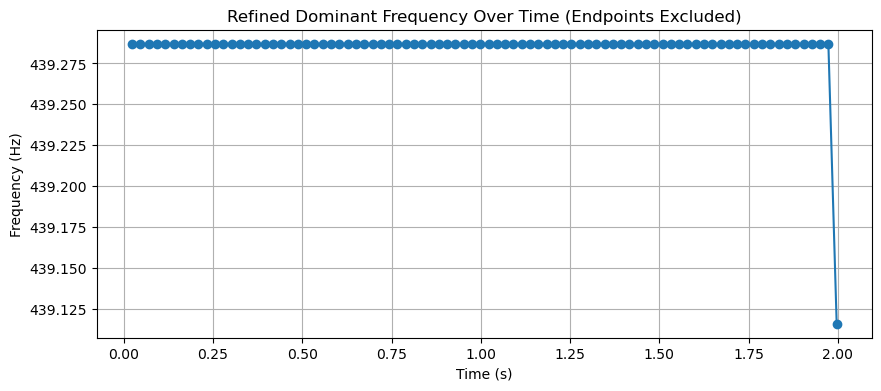

In [38]:
def quadratic_interpolation(magnitudes, peak_idx, bin_width):
    """
    Applies quadratic interpolation around the peak bin to refine the frequency estimate.

    Parameters:
    - magnitudes: Array of magnitudes for frequency bins.
    - peak_idx: Index of the maximum magnitude (peak) in the array.
    - bin_width: The frequency spacing between bins in Hz.

    Returns:
    - Correction (in Hz) to be added to the frequency at peak_idx.
    """
    if peak_idx <= 0 or peak_idx >= len(magnitudes) - 1:
        return 0.0
    # Magnitudes of the peak and its immediate neighbors
    alpha = magnitudes[peak_idx - 1]
    beta = magnitudes[peak_idx]
    gamma = magnitudes[peak_idx + 1]
    
    # Compute the correction factor (delta) based on the parabolic fit
    denominator = alpha - 2 * beta + gamma
    if denominator == 0:
        delta = 0
    else:
        delta = 0.5 * (alpha - gamma) / denominator
    return delta * bin_width

def analyze_stft_interpolated(file_path, window_size=2048, hop_size=1024, window_type='hann'):
    """
    Reads an audio file, computes its STFT, and identifies the refined dominant frequency 
    in each time frame using quadratic interpolation while skipping the endpoints.

    Parameters:
    - file_path: Path to the WAV file.
    - window_size: Number of samples per window.
    - hop_size: Number of samples between successive windows.
    - window_type: Type of window to apply.

    Returns:
    - times: Array of time bins (excluding the first and last frames).
    - interpolated_frequencies: Array of refined dominant frequency (in Hz) per time frame.
    - f: Frequency bins from the STFT.
    - Zxx: STFT complex spectrum.
    """
    # Read the audio file.
    sample_rate, audio_data = read_wav(file_path)
    
    # Compute the STFT.
    f, t, Zxx = stft(audio_data, fs=sample_rate, window=window_type, 
                       nperseg=window_size, noverlap=window_size-hop_size)
    
    # Frequency bin width in Hz (assuming uniform spacing)
    bin_width = f[1] - f[0] if len(f) > 1 else 0
    
    interpolated_frequencies = []
    refined_times = []
    
    # Exclude the first and last time frames to avoid edge artifacts.
    for i in range(1, Zxx.shape[1] - 1):
        magnitudes = np.abs(Zxx[:, i])
        peak_idx = np.argmax(magnitudes)
        # Basic frequency estimate from the peak index.
        basic_freq = f[peak_idx]
        # Calculate correction using quadratic interpolation.
        correction = quadratic_interpolation(magnitudes, peak_idx, bin_width)
        refined_freq = basic_freq + correction
        interpolated_frequencies.append(refined_freq)
        refined_times.append(t[i])
        print(f"Time {t[i]:.3f} s: Refined frequency = {refined_freq:.2f} Hz")
        
    return np.array(refined_times), np.array(interpolated_frequencies), f, Zxx

# Generate an example sine wave file (A4: 440 Hz)
file_path = generate_sine_wave(frequency=440)

# Analyze the audio file using STFT with quadratic interpolation.
times, interpolated_frequencies, f, Zxx = analyze_stft_interpolated(file_path, window_size=2048, hop_size=1024)

# Plot the refined dominant frequency over time.
plt.figure(figsize=(10, 4))
plt.plot(times, interpolated_frequencies, marker='o', linestyle='-')
plt.title("Refined Dominant Frequency Over Time (Endpoints Excluded)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.show()


### Experiments and results

### Discussion

### Conclusion



### Deklarasjon av bruk av generativ kunstig intelligens

"I dette vitenskapelige arbeidet har generativ kunstig intelligens (KI) blitt benyttet. Alle data og personopplysninger er blitt behandlet i henhold til Universitetet i Oslos reglement og jeg som forfatter av dokumentet tar fullt ansvar for dets innhold, påstander og referanser. En oversikt over bruken av generativ KI er gitt under. 

\<1. Generating LaTeX-script 2. Spell-checking 3. Debugging code 4. Finding functions and libraries that match what I need in my proram 5. Creating docstrings and commenting code 6. Creating short code-snippets based on pseudo-code 7. Making clever variable names following convention>"

Mellom <> fyller du inn en punktliste med hva AI er brukt til og hvilken språkmodell som er brukt, f. eks. GPT UiO.